In [60]:
%load_ext autoreload
%autoreload 2

from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSPostMeanScoreMatching  import \
    ConditionalLSTMTSPostMeanScoreMatching

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from src.classes.ClassFractionalBiPotential import FractionalBiPotential
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config as get_config
config = get_config()
print(config.data_path)
print(config.scoreNet_trained_path)
num_paths = 0
num_time_steps = config.ts_length
isUnitInterval = True
diff = 1
initial_state = 0.
rvs = None
H = 0.5
deltaT = config.deltaT
t0 = config.t0
t1 = config.t1
fBiPot = FractionalBiPotential(quartic_coeff=config.quartic_coeff, quad_coeff=config.quad_coeff, const = config.const, diff=diff, X0=initial_state)
if num_paths > 0:
    sim_data = np.array(
        [fBiPot.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                               t0=t0, t1=t1) for _ in (range(num_paths))]).reshape((num_paths, num_time_steps+1))

    plt.hist(sim_data.flatten(), density=True, bins=150)
    print(max(np.abs(sim_data.flatten())))
    plt.show()
    plt.close()
diffs = []
paths = []
for k in range(num_paths):
    path = sim_data[k,:]
    drifts = -(4*config.quartic_coeff * np.power(path[:-1],3) + config.quad_coeff*path[:-1] + config.const)
    plt.scatter(path[:-1], drifts, s=1, label="True")
    d = (np.diff(path)[np.abs(path[1:])<np.inf])
    if len(d) > 0:
        diffs.append(d)
    paths.append(path)
plt.show()
plt.close()
if num_paths > 0 and ("QuadSin" in config.data_path):
    cs, bins, _ = plt.hist(config.sin_space_scale*np.concatenate(diffs).flatten(), bins=100, density=True, label="Histogram")
    print(max(config.sin_space_scale*np.abs(np.concatenate(diffs).flatten())))
    plt.vlines(x=1., ymin=0., ymax=max(cs), color="orange", label="Frequency Limit")
    plt.legend()
    plt.show()
    plt.close()


/Users/marcos/GitHubRepos/FractionalBrownianMotion/data/fBiPot_samples_t00_dT3906e-03_T256_025a_-05b_00c_10Diff_00Init.npy
/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_PM_TSM_2LFac_WRMSE_fBiPot_VPSDE_H50e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20e+01_BetaMin00e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-05b_00c_LSTM_H20_Nly1_tl110


In [62]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift, ts_type,Nepoch,toSave:bool = True):
    fig, ax = plt.subplots(figsize=(14,9))
    rmse = rmse_ignore_nans(true_drift, mean).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    plt.errorbar(numpy_Xs,mean,yerr=[mean-mean_min, mean_max-mean],xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"RMSE {round(rmse,3)} for LSTM Score Estimator", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.tight_layout()
    if toSave:
        plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type}_LSTM_{Nepoch}Nep_{config.deltaT:.3e}dT_{config.loss_factor}LFac.png",  bbox_inches='tight')
    plt.show()
    plt.close()

In [63]:
config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = 1 / config.ts_length

0.0
Using CPU



In [68]:
def get_drift_files(config):
    ts_type = f"BiPot"
    include =  (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
            ".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    drift_files = []
    for file in os.listdir(root_dir):
        if "LSTM" in file and ts_type in file and include in file:
            if "muhats" in file:
                drift_files.append(root_dir+file)
    assert len(drift_files)>0, "No global files found"
    def extract_bw_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    drift_files = sorted(drift_files, key=extract_bw_number)
    Nepochs = [extract_bw_number(f) for f in drift_files]
    return drift_files[:-8], Nepochs[:-8]

In [69]:
drift_files, Nepochs = get_drift_files(config)
Nepochs

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490,
 500,
 510,
 520,
 530,
 540,
 550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,
 630,
 640,
 650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750,
 760,
 770,
 780]

In [70]:
rmses = {}
for f in zip(*[Nepochs, drift_files]):
    Nepoch = f[0]
    file = f[1]
    print(Nepoch, file)
    try:
        if Nepoch > 18190: raise FileNotFoundError
        muhats = torch.Tensor(np.load(file))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
        ts_type="fBiPot"
        true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1).mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        rmses.update({Nepoch: round(rmse, 4)})
    except FileNotFoundError as e:
        print(e)
        continue
rmses


10 /Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fBiPot_DriftEvalExp_10Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_muhats.npy
20 /Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fBiPot_DriftEvalExp_20Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_muhats.npy
30 /Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fBiPot_DriftEvalExp_30Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_muhats.npy
40 /Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fBiPot_DriftEvalExp_40Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_muhats.npy
50 /Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fBiPot_DriftEvalExp_50Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_muhats.npy
60 /Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fBiPot_DriftEvalExp_60Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_muhats.npy
70 /

{10: 0.5865,
 20: 0.5142,
 30: 0.2555,
 40: 0.1906,
 50: 0.2769,
 60: 0.2983,
 70: 0.1907,
 80: 0.1457,
 90: 0.1761,
 100: 0.2596,
 110: 0.1839,
 120: 0.1122,
 130: 0.2338,
 140: 0.2781,
 150: 0.343,
 160: 0.4905,
 170: 0.2093,
 180: 0.15,
 190: 0.2095,
 200: 0.139,
 210: 0.2797,
 220: 0.53,
 230: 0.3052,
 240: 0.3926,
 250: 0.2799,
 260: 0.1142,
 270: 0.1278,
 280: 0.0825,
 290: 0.3982,
 300: 0.069,
 310: 0.2849,
 320: 0.1021,
 330: 0.0774,
 340: 0.5307,
 350: 0.1173,
 360: 0.0843,
 370: 0.1167,
 380: 0.1231,
 390: 0.2815,
 400: 0.1902,
 410: 0.1324,
 420: 0.7623,
 430: 0.1414,
 440: 0.2036,
 450: 0.3789,
 460: 0.2663,
 470: 0.5905,
 480: 0.1403,
 490: 0.2664,
 500: 0.761,
 510: 0.4052,
 520: 0.2627,
 530: 0.2282,
 540: 0.1746,
 550: 0.0931,
 560: 0.2326,
 570: 0.2212,
 580: 0.1212,
 590: 0.2412,
 600: 0.2765,
 610: 0.1563,
 620: 0.2937,
 630: 0.0957,
 640: 0.258,
 650: 0.1018,
 660: 0.3539,
 670: 0.2249,
 680: 0.1726,
 690: 0.3268,
 700: 0.2723,
 710: 0.1509,
 720: 0.4571,
 730: 0.15

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.9847323127799431

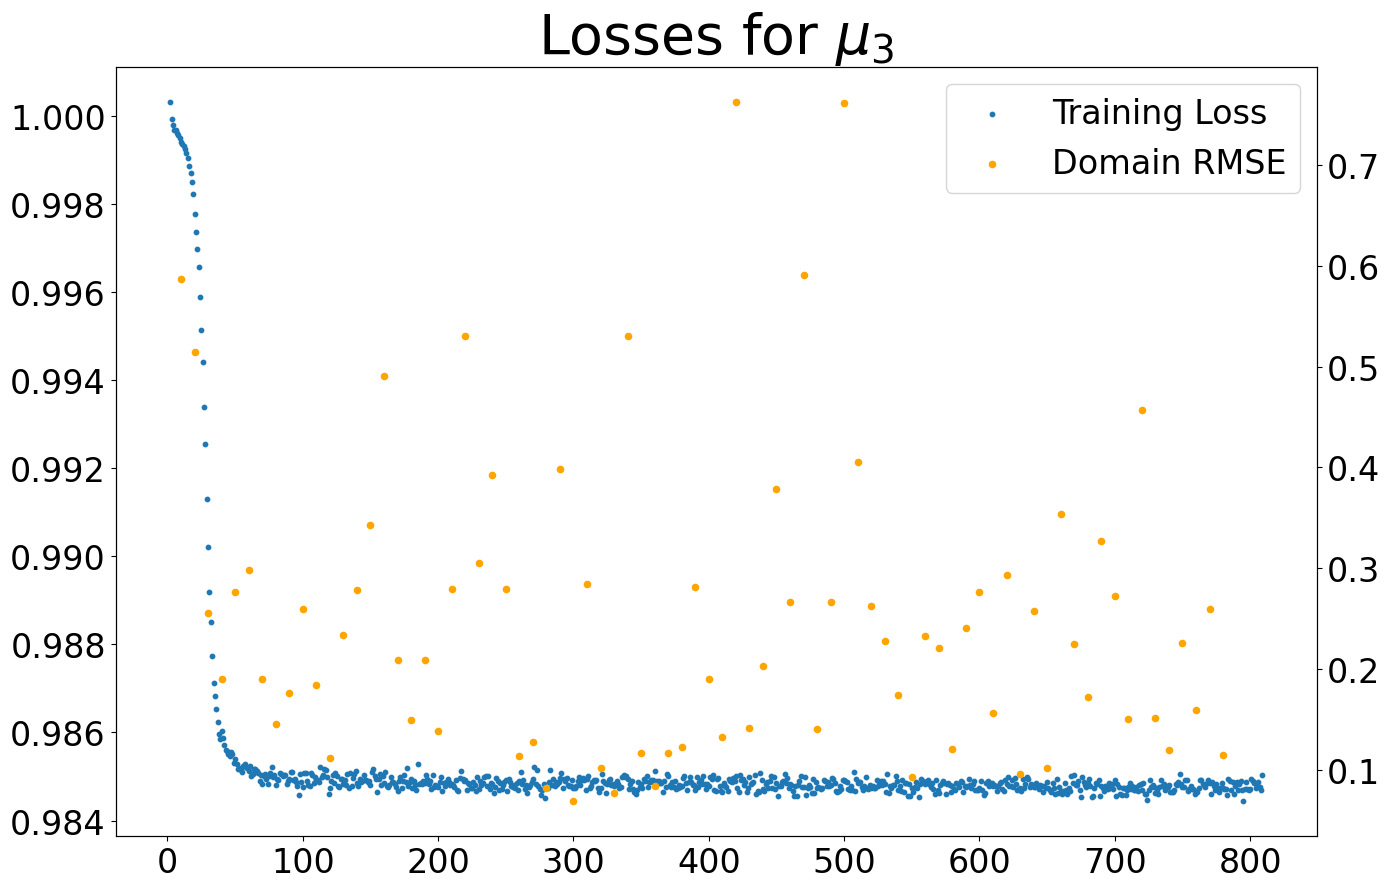

In [72]:
%load_ext autoreload
%autoreload 2
from matplotlib.ticker import LogLocator
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config
gconfig = get_config()
with open(gconfig.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.sqrt(np.array(pickle.load(f)).astype(float))
start_idx = 2
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(np.arange(start_idx, losses.shape[0]), losses[start_idx:], s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
sc2 = ax2.scatter(Nepochs, list(rmses.values()), s=20, color="orange",label="Domain RMSE")
ax2.set_xlabel("Training Epochs", fontsize=38)
ax2.set_title(r"Losses for $\mu_{3}$", fontsize=40)
ax2.tick_params(axis="both",labelsize=24)
#ax.set_yscale("log")
#ax.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto', numticks=10))
#plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fQuadSinHF_DriftTrack_{Nepoch}Nep_PM_LSTM_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(".", "")+".png")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fBiPot_DriftEvalExpLosses_PM_LSTM").replace(".", "")+".png")
losses[-1]/losses[start_idx]

<_io.BufferedReader name='/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/training_losses/trained_rec_ST_PM_TSM_2LFac_fBiPot_VPSDE_H50e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20e+01_BetaMin00e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-05b_00c_LSTM_H20_Nly1_tl110_loss'>


0.36960995240118816

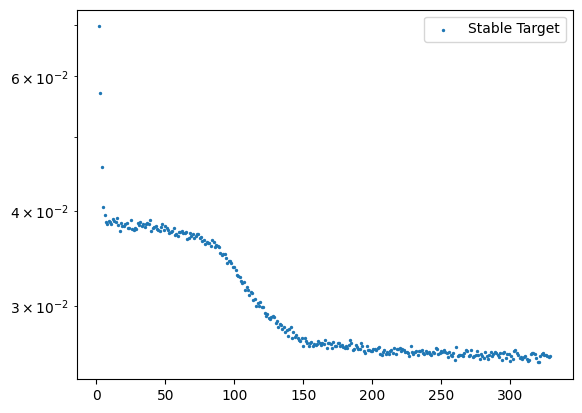

In [48]:
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_SbleTgt import get_config as get_config
gconfig2 = get_config()
with open(gconfig2.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        print(f)
        losses2 = np.array(pickle.load(f))[:losses.shape[0]]
plt.scatter(np.arange(start_idx, losses2.shape[0]), losses2[start_idx:],s=2, label="Stable Target")
#plt.hlines(np.sqrt(config.deltaT), xmin = start_idx, xmax=losses.shape[0]-start_idx, color="red")
plt.yscale("log")
plt.legend()
losses2[-1]/losses2[start_idx]

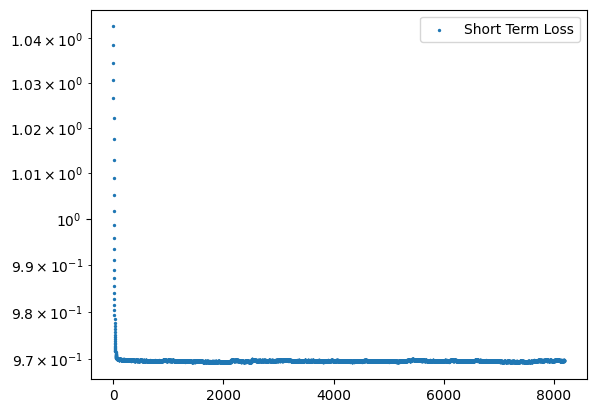

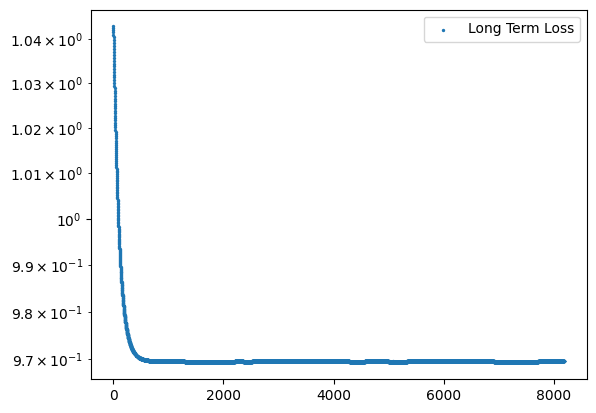

In [162]:
start_idx = 00
def compute_ema(loss_tensor, beta):
    ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
    ema_values[0] = loss_tensor[0]  # First value stays the same

    for i in range(1, len(loss_tensor)):
        ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

    return ema_values
# Define EMA decay rates
beta_short = 0.9   # Short-term trend (reacts quickly)
beta_long = 0.99   # Long-term trend (smoother)

# Compute EMAs
short_term_ema = compute_ema(losses, beta_short)
long_term_ema = compute_ema(losses, beta_long)
plt.scatter(np.arange(start_idx, short_term_ema.shape[0]), (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
plt.yscale("log")
plt.legend()
plt.show()
plt.scatter(np.arange(start_idx, long_term_ema.shape[0]), (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
plt.yscale("log")
plt.legend()
plt.show()

PM fBiPot 10000 torch.Size([256, 1, 10])
[ 1.46727300e+00  1.65728760e+00  1.28480077e+00  1.29528737e+00
  1.39546514e+00  1.17666781e+00  1.04942012e+00  7.53489673e-01
  1.01339114e+00  9.43482995e-01  1.00229800e+00  8.90152991e-01
  6.72119141e-01  7.41281152e-01  8.39334130e-01  8.85607898e-01
  7.04769313e-01  5.29585779e-01  3.69470209e-01  9.68908668e-01
  5.45247674e-01  5.66396117e-01  5.20190418e-01  4.03096020e-01
  3.96601111e-01  3.72460932e-01  1.96312979e-01  3.87652844e-01
  3.05249035e-01  1.82653815e-01  8.12720805e-02  2.34171562e-02
  1.33471683e-01  3.25397253e-02  1.18408203e-02  2.68620090e-03
 -6.77775070e-02 -4.82730865e-02  8.29620380e-03 -1.60095215e-01
 -1.62368771e-02 -1.86189786e-01 -1.73669428e-01 -1.86372370e-01
 -2.06181645e-01 -2.04402164e-01 -2.66638190e-01 -2.57517517e-01
 -2.94587404e-01 -3.12451184e-01 -3.65773529e-01 -3.60690296e-01
 -3.85385126e-01 -3.62637013e-01 -4.04180259e-01 -4.61401373e-01
 -4.51361090e-01 -4.58233654e-01 -4.79980469e-01 

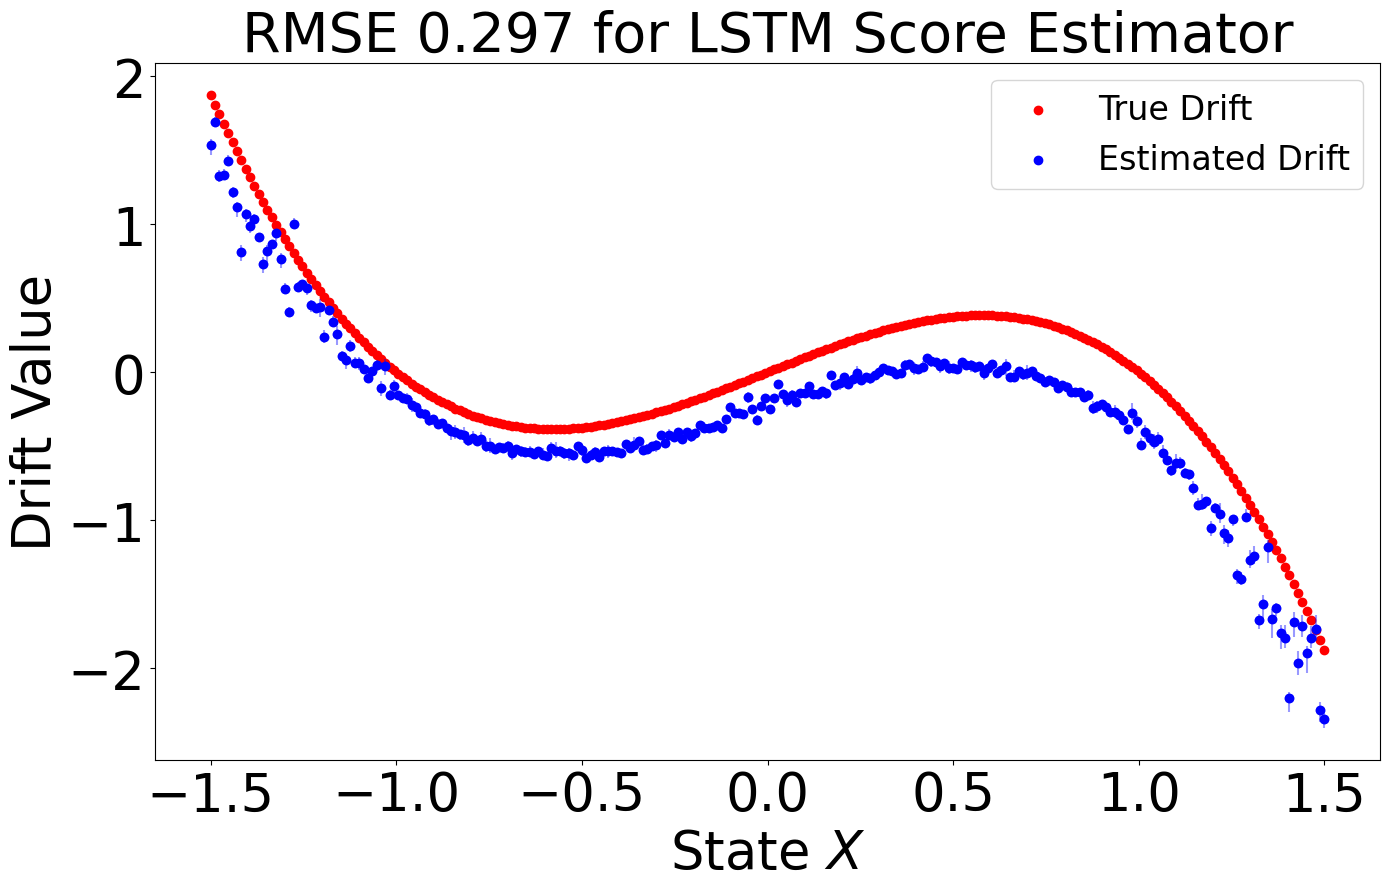

Epoch 60 done with Best RMSE 0.29709526896476746




PM fBiPot 10000 torch.Size([256, 1, 10])
[ 1.27214360e+00  1.38557029e+00  1.09175718e+00  1.16029549e+00
  1.17424619e+00  9.99752283e-01  8.88830543e-01  6.69287086e-01
  8.70500922e-01  8.80157471e-01  7.95146763e-01  6.60280883e-01
  5.60070813e-01  5.14755249e-01  6.53926849e-01  7.02879310e-01
  5.00658154e-01  4.00508642e-01  2.82043457e-01  5.73599279e-01
  4.26428229e-01  2.57771045e-01  2.60162354e-01  1.88903809e-01
  1.29097372e-01  2.56848156e-01  1.03936769e-01  1.76162720e-01
  1.07952878e-01  3.50463875e-02  2.25219736e-03 -8.64095092e-02
 -8.02459717e-02 -7.15539604e-02 -1.51855469e-01 -1.51154444e-01
 -1.78323358e-01 -1.58290863e-01 -1.27970129e-01 -2.61351019e-01
 -2.08862305e-01 -2.81712353e-01 -3.14279169e-01 -3.05178821e-01
 -3.11192006e-01 -3.60948950e-01 -3.39826196e-01 -3.48260492e-01
 -3.83839130e-01 -4.11202610e-01 -4.20864373e-01 -4.52359021e-01
 -4.78345871e-01 -4.50708002e-01 -4.96850193e-01 -5.05102515e

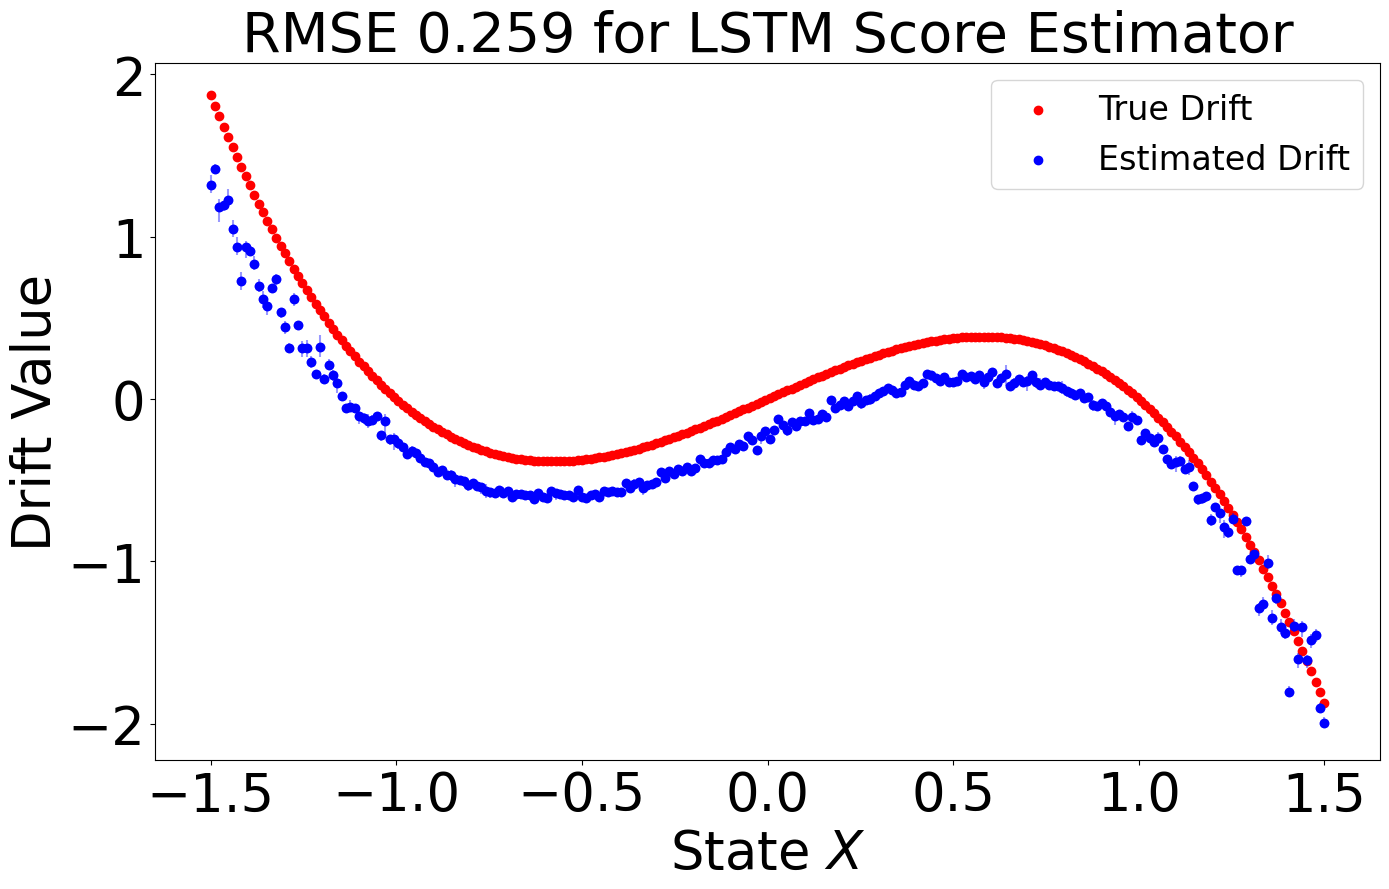

Epoch 100 done with Best RMSE 0.25921565294265747




PM fBiPot 10000 torch.Size([256, 1, 10])
[ 1.2328675   1.170935    1.1778286   1.2168747   1.1079193   1.0452912
  0.897522    0.726889    0.936499    0.93568116  0.78921735  0.67294925
  0.595088    0.50231934  0.6644207   0.70515746  0.4813436   0.46687827
  0.34171754  0.43484092  0.4003418   0.21193849  0.25163573  0.17231445
  0.0972992   0.27441406  0.13576864  0.17015788  0.0867569   0.04493713
  0.01038322 -0.12992606 -0.112677   -0.08402466 -0.1583496  -0.14647545
 -0.16528778 -0.17002258 -0.15932617 -0.2395691  -0.22089843 -0.28591895
 -0.3401367  -0.30468827 -0.30512208 -0.38121337 -0.40266266 -0.38881278
 -0.391864   -0.41683483 -0.46266073 -0.48951644 -0.48197252 -0.48448974
 -0.5008942  -0.5537704  -0.5497681  -0.5554972  -0.5342773  -0.5720993
 -0.6553671  -0.5995865  -0.62740684 -0.65108335 -0.6462158  -0.622998
 -0.6268697  -0.6489952  -0.67338866 -0.660199   -0.6504159  -0.68129885
 -0.63572145 -0.67294616 -0.68276

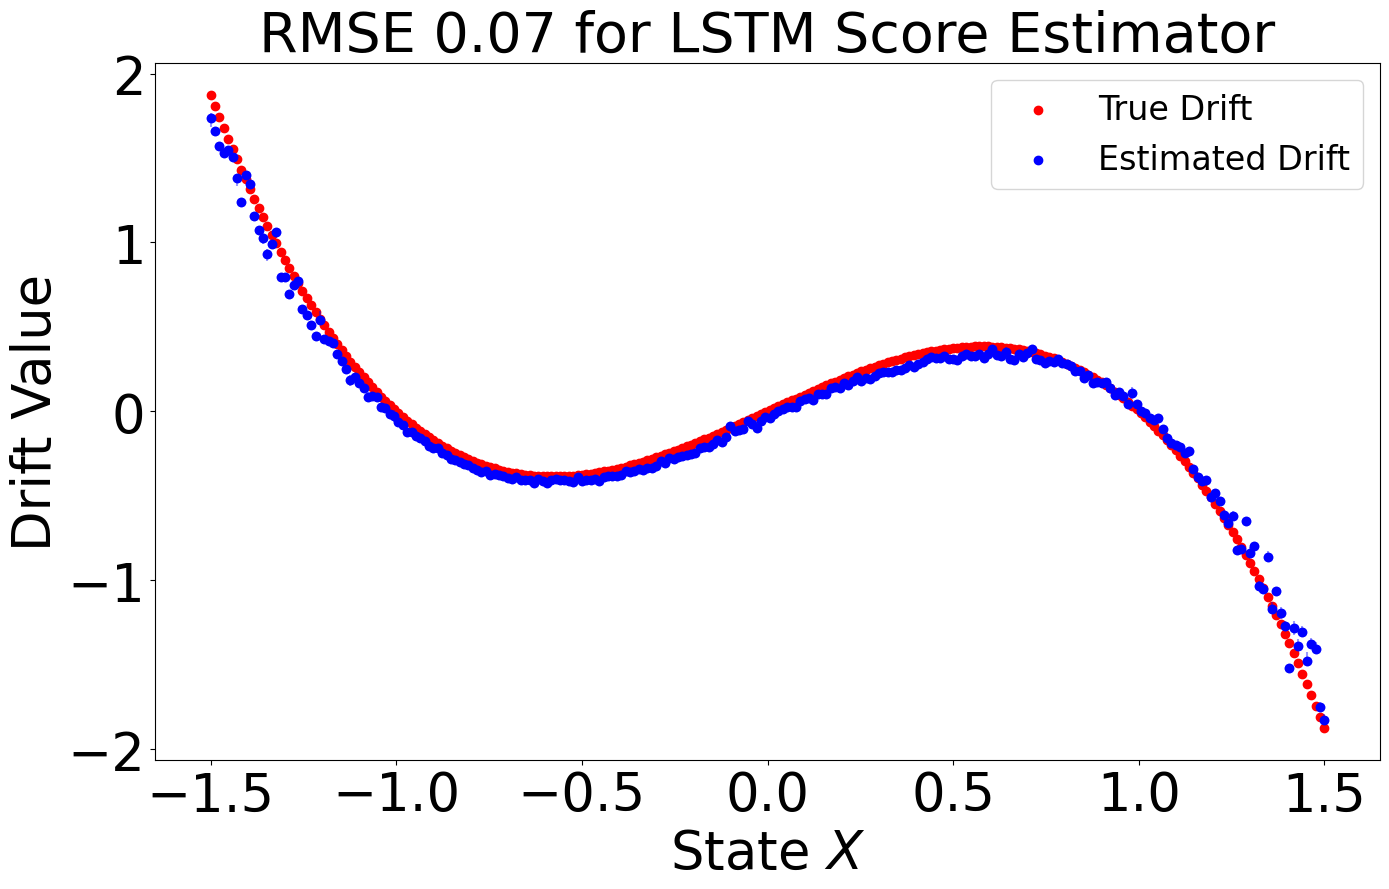

Epoch 300 done with Best RMSE 0.06973110884428024




PM fBiPot 10000 torch.Size([256, 1, 10])
[ 1.9992187   2.0138023   1.8385389   1.588443    1.5444946   1.2951005
  1.7958008   1.5578125   1.4909179   1.4453614   1.0283874   1.1116211
  1.0925782   0.9626953   1.1075561   1.2675292   0.9694214   0.795874
  0.8312744   0.64380187  0.7626953   0.9617839   0.6270264   0.6769287
  0.5525452   0.55512697  0.5194906   0.46094564  0.47722167  0.5095703
  0.42508546  0.45833334  0.33117065  0.3760034   0.30166015  0.2844308
  0.21982932  0.21515504  0.20635375  0.177771    0.1449707   0.14467773
  0.1015625   0.0581604   0.02966797  0.02017212  0.01433105 -0.01117274
 -0.02224609 -0.05817261 -0.04593099 -0.11295166 -0.07498322 -0.08686768
 -0.08457381 -0.18293457 -0.15343425 -0.15138347 -0.14853516 -0.12347211
 -0.18000896 -0.20041749 -0.18260905 -0.21462402 -0.2513916  -0.18095297
 -0.21099718 -0.21594314 -0.1999349  -0.29330242 -0.20476839 -0.2506958
 -0.25827637 -0.23141886 -0.29074937 

In [163]:
best_rmse = np.inf
toSave = False
for Nepoch in config.max_epochs:
    try:
        Ndiff = config.max_diff_steps
        if "PMS" in config.scoreNet_trained_path:
            type = "PMS"
        elif "PM" in config.scoreNet_trained_path:
            type = "PM"
        else:
            type = ""

        if "fSin" in config.data_path:
            file_path = f"/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TS{type}_LSTM_fSin_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_10MeanRev_{Ndiff}DiffSteps_"
        elif "fQuadSinHF" in config.data_path:
            file_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
                            ".", "")
            print(file_path)
        elif "fBiPotSmall" in config.data_path:
            file_path = (
                    project_config.ROOT_DIR + f"experiments/results/TS{type}_LSTM_fBiPotSmall_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.max_diff_steps}DiffSteps_").replace(
                ".", "")
        elif "fBiPot" in config.data_path:
            file_path = (
                        project_config.ROOT_DIR + f"experiments/results/TS{type}_LSTM_fBiPot_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
                    ".", "")
        muhats = torch.Tensor(np.load(file_path+"muhats.npy"))
        Xshape = muhats.shape[0]
        if "fQuadSinHF" in config.data_path:
            if config.deltaT > 1/(32*256):
                Xs = torch.linspace(-1.5, 1.5, steps=Xshape)
            else:
                Xs = torch.linspace(-.4, .4, steps=Xshape)
            ts_type = "fQuadSinHF"
        elif "fSin" in config.data_path:
            Xs = torch.Tensor(np.linspace(-3,3,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type = "fSin"
        elif "fBiPotSmall" in config.data_path:
            Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type="fBiPotSmall"
        elif "fBiPot" in config.data_path:
            Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type="fBiPot"
        if type == "":
            type="Standard"
        print(type, ts_type, Ndiff, muhats.shape)
        assert (config.max_diff_steps == 10000)
        if "fQuadSin" in config.data_path:
            true_drifts = -2.*config.quad_coeff * Xs.unsqueeze(-1) + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*Xs).unsqueeze(-1)
            print(config.quad_coeff, config.sin_coeff, config.sin_space_scale)
        elif "fSin" in config.data_path:
            true_drifts = config.mean_rev*np.sin(1*Xs).unsqueeze(-1)
        elif "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).unsqueeze(-1)
            #true_drifts = true_drifts/(1.+config.deltaT*torch.abs(true_drifts))
        muhats =  muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1)
        mu_hats = muhats.mean(dim=-1).numpy() # Pointwise drift estimate
        mu_hats_minq = muhats.quantile(dim=-1, q=0.025).numpy() # Lower bound
        mu_hats_maxq = muhats.quantile(dim=-1, q=0.975).numpy() # Lower bound
        print(mu_hats_minq, mu_hats_maxq)
        stds = muhats.std(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts.numpy(), mu_hats).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
        if rmse < best_rmse:
            best_rmse = rmse
            plot_drift_estimator(mean=mu_hats, mean_min=mu_hats_minq, mean_max=mu_hats_maxq, numpy_Xs=Xs.numpy(),  toSave=toSave, true_drift=true_drifts.numpy(), ts_type=ts_type, Nepoch=Nepoch)
        print(f"Epoch {Nepoch} done with Best RMSE {best_rmse}\n\n\n\n")
        del muhats, mu_hats, stds, true_drifts
    except FileNotFoundError as e:
        print(e)
        continue